# Notes

This notebook updates Pipe_Creation_Plus_LSS_6.ipynb.

- It builds upon the Zhang+20 method of creating DMs from the TNG simulation.
- It improves upon this by correcting ElectronAbundance in star-forming regions using the Pakmor+18 method allowing them to be used. To do this it calculates the warm-phase gas mass fraction W (=1-X, where X is from Marinacci+17)
- It identifies LSS using the Artale+21 method.
- It inserts code developed to load snapshots partwise to handle larger simulations
- It saves output data to file as it is created, which allows it to be stopped and resumed rather than being started from scratch.
- It removes unecessary tests and plots and incorporates all code into a single cell, which can be copied into a .py file to be run as a batch job.
- It stores Particle ID and location information which can be used to calculate halo impact factors along tthe line of sight.
- It contains an option for multiprocessing different pipes on multiple cpus simultaneously to speed up pipe creation

Notes: 

- The lines of code which save pipes have been commented out in this version of the code in order not to overwrite existing file
- When running on a Jupyter notebook, it seems to begin failing after requesting around 6-7+ cpus simultaneously. This may be an issue with the interactive nodes. Hopeefully, in a script we should be able to use many more (50-70)

ELECTRON DENSITY OF SFR CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/oct2_2021_output/IGM_new_scripts/job_raven.py, raven:/u/cwalker/Illustris_FRB_Project/charlie_TNG_lib/charlie_TNG_tools.py
PAPERS: Marinacci+17: https://arxiv.org/abs/1610.01594, Pakmor+18: https://arxiv.org/abs/1807.02113

PIPE CREATION CODE ARCHIVE

raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Test.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb, raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Plus_LSS.ipynb
PAPERS: Zhang+20: https://arxiv.org/abs/2011.14494

LSS CLASSIFICATION CODE ARCHIVE

raven:/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/SCRIPT_Cel_Auto.py, raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb
PAPERS: Artale+21: https://arxiv.org/abs/2102.01092

PARTWISE SIMULATION LOADING ARCHIVE

raven:/u/cwalker/Illustris_Zhang_Method/Test_Subset_Loading.ipynb


# Imports

In [1]:
import illustris_python as il
import numpy as np
import multiprocessing as m
from multiprocessing import Pool
from contextlib import closing

from numpy import random as rand
from charlie_TNG_tools import temp2u
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd
from astropy import constants as c
#from artale_constants import *
from astropy.cosmology import Planck15 as cosmosource
import h5py
import os

# Functions

In [2]:
def gadgetDens2SI(dens):
    """
    Original Artale function to convert TNG densities to SI units

    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*cel_Msol_si/cel_hubble/(cel_kpc_si/cel_hubble)**3

def TNG_Dens2SI(dens):
    """
    Like gadgetDens2SI but using astropy values for constants
    Strips result of units
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*c.M_sun.to('kg').value/cosmosource.h/(c.kpc.to('m').value/cosmosource.h)**3

def TNG_Dens2SI_astropy(dens):
    """
    Like TNG_Dens2SI but does not strip result of units.
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """

    return dens*1E10*c.M_sun.to('kg')/cosmosource.h/(c.kpc.to('m')/cosmosource.h)**3

   
def pSplitRange(indrange, numProcs, curProc, inclusive=False):
    """ Divide work for embarassingly parallel problems. 
    Accept a 2-tuple of [start,end] indices and return a new range subset.
    If inclusive==True, then assume the range subset will be used e.g. as input to snapshotSubseet(),
    which unlike numpy convention is inclusive in the indices."""
    assert len(indrange) == 2 and indrange[1] > indrange[0]

    if numProcs == 1:
        if curProc != 0:
            raise Exception("Only a single processor but requested curProc>0.")
        return indrange

    # split array into numProcs segments, and return the curProc'th segment
    splitSize = int(np.floor( (indrange[1]-indrange[0]) / numProcs ))
    start = indrange[0] + curProc*splitSize
    end   = indrange[0] + (curProc+1)*splitSize

    # for last split, make sure it takes any leftovers
    if curProc == numProcs-1:
        end = indrange[1]

    if inclusive and curProc < numProcs-1:
        # not for last split/final index, because this should be e.g. NumPart[0]-1 already
        end -= 1

    return [start,end]


def loadSubset(simPath, snap, partType, fields, chunkNum=0, totNumChunks=1):
    """ 
    Load part of a snapshot.
    frm Dylan Nelson: https://www.tng-project.org/data/forum/topic/203/loading-the-tng100-1-data/
    """
    nTypes = 6
    ptNum = il.util.partTypeNum(partType)

    with h5py.File(il.snapshot.snapPath(simPath,snap),'r') as f:
        numPartTot = il.snapshot.getNumPart( dict(f['Header'].attrs.items()) )[ptNum]

    # define index range
    indRange_fullSnap = [0,numPartTot-1]
    indRange = pSplitRange(indRange_fullSnap, totNumChunks, chunkNum, inclusive=True)

    # load a contiguous chunk by making a subset specification in analogy to the group ordered loads
    subset = { 'offsetType'  : np.zeros(nTypes, dtype='int64'),
               'lenType'     : np.zeros(nTypes, dtype='int64') }

    subset['offsetType'][ptNum] = indRange[0]
    subset['lenType'][ptNum]    = indRange[1]-indRange[0]+1

    # add snap offsets (as required)
    with h5py.File(il.snapshot.offsetPath(simPath,snap),'r') as f:
        subset['snapOffsets'] = np.transpose(f['FileOffsets/SnapByType'][()])

    # load from disk
    r = il.snapshot.loadSubset(simPath, snap, partType, fields, subset=subset)

    return r
    


# Begin

In [3]:

############
#initialise#
############

sim_to_use = 'TNG50-4'
print('Simulation to use will be: {0}'.format(sim_to_use))

pipes_per_snap = 1
print('Number of pipes to create per snapshot: {0}'.format(pipes_per_snap))

snaps_to_process = [99]#,91,84,78,72,67,59,50,40,33,25,21,17]#,13,11,8,6,4,3,2]
print('Snapshots to process will be {0}'.format(snaps_to_process))

#The number of cells in the chosen snapshot
#ncells = dataPT0['Coordinates'].shape[0]
#print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))

nSubLoads = 100 #number of subloads to split simulation into

#pipe info for test
npipes      = 1  #number of pipes to create
snap_number = 99 #snapshot number for test


#base path to simulation
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

#load header
header = il.groupcat.loadHeader(basePath,snap_number)

#fields to load for test
fields=['Density',
        'ElectronAbundance',
        'StarFormationRate',
        'InternalEnergy',
        'Coordinates',
        'Masses',
        'SubfindDMDensity',
        'ParticleIDs'] 

#define constants foor warm-phase gas mass fraction calculation
T_h = 10**7  #hot phase gase temperature [Kelvin] 
T_c = 10**3  #cold phase gas temperature [Kelvin]
x_h = 0.75   #Hydrogen mass fraction


Simulation to use will be: TNG50-4
Number of pipes to create per snapshot: 1
Snapshots to process will be [99]
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


# Version of the code which sequentially loads parts of the simulation

In [ ]:
#####################
#Loop over snapshots#
#####################

for snapshot_to_process in range(len(snaps_to_process)):
   
    ############
    #initialise#
    ############
    
    npipes            = pipes_per_snap  #number of pipes to create
    snap_number       = snaps_to_process[snapshot_to_process] #snapshot number for test
    
    print('Currently processing snapshot: {0}'.format(snap_number))
    
    
    #############
    #load header#
    #############
    
    header = il.groupcat.loadHeader(basePath,snap_number)
    print('Header for snap = {0}'.format(header))
    
    
    #load the particle and subhalo ID lists for all cells in the desired simulation
    AllPartIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/PartList_Snap{1}.npy'.format(sim_to_use,snap_number))
    AllSubhIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/ShIDList_Snap{1}.npy'.format(sim_to_use,snap_number))

            
    #######################################################
    #######################################################
    ##Check that file to store data dictionary in exists.##
    ##If it doesn't, create it and initialise it.        ##
    ##If it does, load it.                               ##
    #######################################################
    #######################################################
    
    #HACK FOR TESTING, REVERT OUTFILE NAME WHEN PUTTING IN ACTUAL SCRIPT!
    
    #outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output.npy'.format(sim_to_use,snap_number) #name of this file
    outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output_pID_test.npy'.format(sim_to_use,snap_number) #name of this file
 
    #####################################
    #check to see if file already exists#
    #####################################
        
    if not os.path.isfile('./{0}'.format(outfile_name)):
        print('Warning: file {0} does not yet exist. Must be created.'.format(outfile_name))
        existcheck = False
    else:
        print('Note: File {0} already exists. Will be loaded.'.format(outfile_name))
        existcheck = True
        
    ######################
    #if file exists, load#
    ######################
    if existcheck == True:
        print('Loading file ({0})'.format(outfile_name))
        dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
        print('File loaded has {0} keys'.format(len(dict_to_edit)))
    
    
    ##############################################
    #if file doesn't exist, create and initialise#
    ##############################################
    
    if existcheck == False:
        print('Creating file ({0})'.format(outfile_name))
        dict_to_edit = {} # initialise
        
        #initialise keys to be stored
        dict_to_edit['dDMdz_Zhang'] = []
        dict_to_edit['dDMdzHalo_Zhang'] = []
        dict_to_edit['dDMdzFilament_Zhang'] = []
        dict_to_edit['dDMdzVoid_Zhang'] = []
        dict_to_edit['nHalo_Zhang'] = []
        dict_to_edit['nFilament_Zhang'] = []
        dict_to_edit['nVoid_Zhang'] = []

        dict_to_edit['dDMdz_Pakmor'] = []
        dict_to_edit['dDMdzHalo_Pakmor'] = []
        dict_to_edit['dDMdzFilament_Pakmor'] = []
        dict_to_edit['dDMdzVoid_Pakmor'] = []
        dict_to_edit['nHalo_Pakmor'] = []
        dict_to_edit['nFilament_Pakmor'] = []
        dict_to_edit['nVoid_Pakmor'] = []
        
        #save
        np.save('./{0}'.format(outfile_name),dict_to_edit)
        print('File created and initialised')
        
        
    #######################################################
    #check to see if file contains correct number of pipes#
    #######################################################
    
    if len(dict_to_edit['dDMdz_Pakmor'])<npipes:
        print('Warning: File currently contains too few pipes ({0}/{1})'.format(len(dict_to_edit['dDMdz_Pakmor']),npipes))
        lencheck = False
    
    elif len(dict_to_edit['dDMdz_Pakmor'])==npipes:
        print('Warning: File already contains the correct number of pipes ({0}). No more will be created'.format(len(dict_to_edit['dDMdz_Pakmor'])))
        lencheck = True
    
    ###################################################################
    #if number of pipes is too low, calculate how many more are needed#
    ###################################################################
    
    if lencheck == False:
        new_npipes = npipes - len(dict_to_edit['dDMdz_Pakmor'])
        print('Remaining number of pipes needed is: {0}'.format(new_npipes))
    
    #####################################
    #if number of pipes is correct, exit#
    #####################################
    
    if lencheck == True:
        print('No new pipes needed. Quitting program.')
        #break

    
    ###########################
    ###########################
    ##create pipes, get dDMdz##
    ###########################
    ###########################
    elif lencheck==False:
        while(len(dict_to_edit['dDMdz_Pakmor'])<npipes): #while not enough pipes have been created:

            #############
            #Create Pipe#
            #############

            #HACK FOR TESTING TO MAKEE SURE IT ONLY LOOPS ONCE. REMOVE BEFORRE PUTTING IN SCRIPT!
            npipes = 0

            #########################################
            #define los coordinates at start of pipe#
            #########################################

            #By Zhang+20 definition of following x-axis,
            #x will be zero, y and z will be random
            #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)

            pipe_start_coords = np.array([0,
                                 np.random.uniform(0,header['BoxSize'],1)[0],
                                 np.random.uniform(0,header['BoxSize'],1)[0]])
            #print('Random start cell coordinates: {0}'.format(pipe_start_coords))

            ###################################
            #define coordinates at end of pipe#
            ###################################

            #By Zhang+20 definition of following x-axis,
            #x will be length of simulation,y and z will be same as start coords

            pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
            #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))


            ########################
            #plot the line of sight#
            ########################

            los_toplot=list(zip(pipe_start_coords,pipe_end_coords))

            ########################
            #construct pipe corners#
            ########################

            #Add and subtract half of pipe length from y and z coords for y and z boundaries
            #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube

            c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
            c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
            c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
            c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4

            c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
            c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
            c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
            c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4

            corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])

            ######################
            #construct pipe edges#
            ######################

            line1 = list(zip(c1s,c1e))
            line2 = list(zip(c2s,c2e))
            line3 = list(zip(c3s,c3e))
            line4 = list(zip(c4s,c4e))
            line5 = list(zip(c1s,c3s))
            line6 = list(zip(c3s,c2s))
            line7 = list(zip(c2s,c4s))
            line8 = list(zip(c4s,c1s))
            line9 = list(zip(c1e,c3e))
            line10 = list(zip(c3e,c2e))
            line11 = list(zip(c2e,c4e))
            line12 = list(zip(c4e,c1e))

            lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])

            ###########################################
            #get cells in this pipe by partial loading#
            ###########################################

            #initialise
            pipe_cell_coords_part=[]
            pipe_cell_dens_part = []
            pipe_cell_elab_part=[]
            pipe_cell_sfr_part=[]
            pipe_cell_dark_part = []
            pipe_cell_warm_part=[]
            pipe_cell_pIDs_part=[]

            #########################
            #loop over partial loads#
            #########################

            for j in range(nSubLoads):

                ###########################
                #load the partial data set#
                ###########################

                data = loadSubset(basePath,snap_number, 'gas', fields,chunkNum=j, totNumChunks=nSubLoads)

                #####################################
                #create warm-phase gas mass fraction#
                #####################################

                density = data['Density'] #the density values along the light ray in gcm**-3
                sfr     = data['StarFormationRate'] #the star formation rate along the light ray in g/s
                ie      = data['InternalEnergy'] #the internal energy along the light ray in erg/g
                ea      = data['ElectronAbundance'] #the electron abundance along the light ray
                #calculate x and w, cold and warm phase gas mass fractions
                x_frac = (temp2u(T_h,ea)-ie)/(temp2u(T_h,ea)-temp2u(T_c,ea)) #cold phase mass fraction
                w_frac = 1 - x_frac # warm phase mass fraction
                #only modify electron abundance if sfr = 0
                w_frac[np.where(sfr==0)]=1
                data['Warm']=w_frac    

                ########################
                #get cells in this pipe#
                ########################

                yz_pts = data['Coordinates'][:,[1,2]]
                ur = c1s[1:] #upper right of pipe start (y and z only)
                ll = c2e[1:] #lower left of pipe end (y and z only)
                inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe

                ###########################
                #get data of cells in pipe#
                ###########################

                pipe_cell_coords_part.append(data['Coordinates'][inidx])       #coordinates [ckpc/h]
                pipe_cell_dens_part.append(data['Density'][inidx])           #densities [(1e10Msun/h)/(ckpc/h)**3]
                pipe_cell_elab_part.append(data['ElectronAbundance'][inidx]) #electron abundance [-]
                pipe_cell_sfr_part.append(data['StarFormationRate'][inidx]) #star formation rate [Msun/yr]
                pipe_cell_dark_part.append(data['SubfindDMDensity'][inidx])  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
                pipe_cell_warm_part.append(data['Warm'][inidx])
                pipe_cell_pIDs_part.append(data['ParticleIDs'][inidx])

            #############################
            #flatten into correct format#
            #############################

            pipe_cell_coords = np.array([item for sublist in pipe_cell_coords_part for item in sublist])
            pipe_cell_dens   = np.array([item for sublist in pipe_cell_dens_part for item in sublist])
            pipe_cell_elab   = np.array([item for sublist in pipe_cell_elab_part for item in sublist])
            pipe_cell_sfr    = np.array([item for sublist in pipe_cell_sfr_part for item in sublist])
            pipe_cell_dark   = np.array([item for sublist in pipe_cell_dark_part for item in sublist])
            pipe_cell_warm   = np.array([item for sublist in pipe_cell_warm_part for item in sublist])
            pipe_cell_pIDs   = np.array([item for sublist in pipe_cell_pIDs_part for item in sublist])

            ############################
            ############################
            ##partial load insert ends##
            ############################
            ############################
            
            ############################
            ############################
            ##subhalo ID insert begins##
            ############################
            ############################
            
            #####################################
            #Convert particle IDs to subhalo ids#
            #####################################
            
            #print('Conversion check')
            
            #create a set of particle IDs for the cells in this pipe
            PartID_Set = set(pipe_cell_pIDs.tolist())
            
            #initialise an array to contain the corresponding positions within the simulation of these cells
            sim_inds = np.zeros(pipe_cell_pIDs.shape,dtype=int)
            
            #loop over all particle IDs in the desired simulation
            for i, x in enumerate(AllPartIDs):
            
                #find when particle ID is also in the pipe
                if x in PartID_Set:
            
                    #find where that particle ID is in the pipe
                    pipe_idx = np.where(pipe_cell_pIDs==x)
                    
                    #assign the pipe at that point the cell's corresponding simulation position
                    sim_inds[pipe_idx] = i
                    
            
            #for all of these simulation positions, get the correct subhalo ID
            pipe_cell_shIDs = np.array(AllSubhIDs[sim_inds])
            #print(pipe_cell_shIDs)
            
            #print('CConversion check end')
            
            ##########################
            ##########################
            ##subhalo ID insert ends##
            ##########################
            ##########################
            
            ############################################################
            #For pure Zhang+20 method, exclude all star forming regions#
            ############################################################

            pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
            pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
            pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
            pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
            pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
            pipe_cell_pIDs_z = pipe_cell_pIDs[np.where(pipe_cell_sfr==0)]
            pipe_cell_shIDs_z = pipe_cell_shIDs[np.where(pipe_cell_sfr==0)]

            #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))

            #############################################################################################
            #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
            #############################################################################################

            pipe_cell_coords_p = pipe_cell_coords[:]
            pipe_cell_dens_p   = pipe_cell_dens[:]
            pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
            pipe_cell_sfr_p    = pipe_cell_sfr[:]
            pipe_cell_dark_p   = pipe_cell_dark[:]
            pipe_cell_pIDs_p   = pipe_cell_pIDs[:]
            pipe_cell_shIDs_p  = pipe_cell_shIDs[:]
            
            #print(pipe_cell_pIDs_p)
            #print(pipe_cell_shIDs_p)
                
            
            ###############################################
            #divide pipe into 10,000 bins along the x-axis#
            ###############################################

            #Question: why 10,000 bins given there are so few particles in the pipe?

            pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
            #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))

            #######################################
            #get coordinates of center of each bin#
            #######################################

            pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])


            ###############################################################
            #for each bin, find distance between it and every cell in pipe#
            #find the one with miniimum distance                          #
            #this will be the cell in the los                             #
            #do for zhang (excluding sfr) and non-zhang (including sfr)   #
            ###############################################################


            ###########
            #Pakmor   #
            ###########

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_p = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_p.append(nearest) #append to array

            nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
            nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.

            ##############
            #zhang method#
            ##############

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_z = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_z.append(nearest) #append to array

            nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
            nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.

            #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
            #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))

            #################################
            #extract data from nearest cells#
            #################################

            ###########
            #Pakmor   #
            ###########

            pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
            pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
            pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
            pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_pIDs_p   = np.array(pipe_cell_pIDs_p[nearest_idxs_p])   #particle ID numbers
            pipe_nearest_shIDs_p  = np.array(pipe_cell_shIDs_p[nearest_idxs_p])  #subhalo ID numbers
            
            #######
            #zhang#
            #######
            
            pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
            pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
            pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
            pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3] 
            pipe_nearest_pIDs_z   = np.array(pipe_cell_pIDs_z[nearest_idxs_z])   #particle ID numbers
            pipe_nearest_shIDs_z  = np.array(pipe_cell_shIDs_z[nearest_idxs_z])  #particle ID numbers
            
            print(pipe_nearest_shIDs_p)
            
            #############################################
            #############################################
            ##subhalo central coordinates insert begins##
            #############################################
            #############################################
            
            #for each subhalo id number, load that subhalo's central position and store
            
            
            ###########################################
            ###########################################
            ##subhalo central coordinates insert ends##
            ###########################################
            ###########################################
            
            
            ###############################################
            #convert density to si units using artale code#
            ###############################################

            pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)
            pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)

            ###########################################################
            #convert dark matter density to si units using artale code#
            ###########################################################

            pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)         
            pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z)         

            #########################################################################
            #divide dark matter density by critical density to create the LSS tracer#
            #########################################################################

            pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
            pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
            #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))        

            ##########################################
            #Create Large-Scale Structure (LSS) masks#
            ##########################################

            #non-zhang
            voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
            fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
            hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 

            #zhang
            voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
            fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
            hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57         

            ##############################################################
            #Calculate the number of nearest cells of each structure type#
            ##############################################################



            num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0_z])[0]
            num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0_z])[0]
            num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0_z])[0]

            num_voi_cells_p = np.shape(pipe_nearest_coords_p[voi_mask_PT0_p])[0]
            num_fil_cells_p = np.shape(pipe_nearest_coords_p[fil_mask_PT0_p])[0]
            num_hal_cells_p = np.shape(pipe_nearest_coords_p[hal_mask_PT0_p])[0]

            ##########################################
            #get electron density at each of the bins#
            ##########################################

            #follow zhang+20 equation exactly as native units of TNG are
            #comoving

            #############################################################
            #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use data which excludes SFRs                               #
            #############################################################

            #total
            pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
            #print('pnes are: {0}'.format(pipe_nearest_pne_z))

            #halos
            pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_hal = (pipe_nearest_elab_z[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))

            #filaments
            pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))

            #voids
            pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_voi = (pipe_nearest_elab_z[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))


            ######################################################################
            #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use all data (sfr included) and warm mass fraction                  #
            ######################################################################    

            ##################################
            #average these electron densities#
            ##################################

            #Zhang method/Pakmor method

            #total
            pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
            pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
            #print('Average pne is: {0}'.format(pipe_average_pne_z))   

            #halos
            pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
            pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
            #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))

            #filaments
            pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
            pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
            #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))

            #voids
            pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
            pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
            #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))


            ################################
            #calculate dDM/dz for this pipe#
            ################################

            #outer bit of eq 7
            outer=c.c/cosmosource.H(0)
            #print(outer)

            #E(z) according to paper eq 5
            Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
            #print(Ez)

            #denominator of eq 7
            denominator = ((1+header['Redshift'])**(2))*Ez

            #remainder of equation 7

            #total
            edens_z = pipe_average_pne_z
            ddmdz_z = outer*edens_z/denominator
            edens_p = pipe_average_pne_p
            ddmdz_p = outer*edens_p/denominator
            #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))

            #halos
            edens_z_hal = pipe_average_pne_z_hal
            ddmdz_z_hal = outer*edens_z_hal/denominator
            edens_p_hal = pipe_average_pne_p_hal
            ddmdz_p_hal = outer*edens_p_hal/denominator

            #filaments
            edens_z_fil = pipe_average_pne_z_fil
            ddmdz_z_fil = outer*edens_z_fil/denominator
            edens_p_fil = pipe_average_pne_p_fil
            ddmdz_p_fil = outer*edens_p_fil/denominator

            #voids
            edens_z_voi = pipe_average_pne_z_voi
            ddmdz_z_voi = outer*edens_z_voi/denominator
            edens_p_voi = pipe_average_pne_p_voi
            ddmdz_p_voi = outer*edens_p_voi/denominator

            ################################
            #append new data to dictionary #
            ################################

            dict_to_edit['dDMdz_Zhang'].append(ddmdz_z.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Zhang'].append(ddmdz_z_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Zhang'].append(ddmdz_z_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Zhang'].append(ddmdz_z_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Zhang'].append(num_hal_cells_z) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Zhang'].append(num_fil_cells_z) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Zhang'].append(num_voi_cells_z) #append number of cells in voids used to get this dDM/dz value to array

            dict_to_edit['dDMdz_Pakmor'].append(ddmdz_p.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Pakmor'].append(ddmdz_p_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Pakmor'].append(ddmdz_p_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Pakmor'].append(ddmdz_p_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Pakmor'].append(num_hal_cells_p) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Pakmor'].append(num_fil_cells_p) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Pakmor'].append(num_voi_cells_p) #append number of cells in voids used to get this dDM/dz value to array

            #########################
            #save updated dictionary#
            #########################
            #np.save('./{0}'.format(outfile_name),dict_to_edit)  NOTE: MUST EDIT BACK IN FOR SCRIPT VERSION!

            ###########################
            #reload updated dictionary#
            ###########################
            dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
            print('New length = {0}'.format(len(dict_to_edit['dDMdz_Pakmor'])))

        ###############################
        ##Once snapshot is done, print#
        ###############################

        print('Completed and stored {0}\n with {1} keys of length {2}\n'.format(outfile_name,len(dict_to_edit),len(dict_to_edit['dDMdz_Pakmor'])))






# Copy of the code where the partial loading is done in parallel

## Testing multiprocessing section

### Functions

In [4]:
def process_sim_chunk(snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e):
    """
    processes part of the simulation on a single cpu. Is fed by unwrap_package().
    this is specifically for pipes going along the x-axis from 0 to box length.
    
    
    INPUTS:
    
    snap_number : [int] the snapshot number of the simulation to be processed
    basePath    : [str] the path to the simulation data to be processed
    sim_to_use  : [str] the simulation to be processed
    nSubLoads   : [int] the total number of parts the simulation will be split into
    chunkIDs    : [array of ints] the id numbers of the chunks of simulation to be processed on this cpu
    T_h         : [= 10**7]  hot phase gase temperature [Kelvin] 
    T_c         : [= 10**3]  cold phase gas temperature [Kelvin]
    c1s         : [0,pipe_width/2,pipe_width/2] coordinates at upper right of pipe start
    c2e         : [0,-pipe_width/2,-pipe_width/2] coordinates at lower left of pipe end
    
    
    RETURNS:
    
    """
    
    verbose = True
    
    for i in range(len(chunkIDs)): #loop over all chunk ids
        
        chunkID = chunkIDs[i] # the chunk ID to be processed
        
        if verbose == True:
            print('Verbose mode check: chunkID = {0}'.format(chunkID))
        
        temp_dict = {} #initialise dictionary to store data for this chunk in
        
        #the name of the file dictionary for this chunk will be stored in
        part_outdata_filename = '/u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_{0:02d}_snap_{1:03d}_cID_{2}.npy'.format(snap_number,chunkID,sim_to_use) 
        
        if verbose == True:
            print('Verbose mode check: store data at = {0}'.format(part_outdata_filename))
            
            
        #initialise arrays to hold the desired information about
        #the simulation cells in this part of the simulation

        #pipe_cell_coords_part=[]
        #pipe_cell_dens_part = []
        #pipe_cell_elab_part=[]
        #pipe_cell_sfr_part=[]
        #pipe_cell_dark_part = []
        #pipe_cell_warm_part=[]
        #pipe_cell_pIDs_part=[]

        ###########################
        #load the partial data set#
        ###########################

        data = loadSubset(basePath,snap_number, 'gas', fields,chunkNum=chunkID, totNumChunks=nSubLoads)
        
        if verbose == True:
            print('Verbose mode check: data = {0}'.format(data))

        #####################################
        #create warm-phase gas mass fraction#
        #####################################

        density = data['Density'] #the density values along the light ray in gcm**-3
        sfr     = data['StarFormationRate'] #the star formation rate along the light ray in g/s
        ie      = data['InternalEnergy'] #the internal energy along the light ray in erg/g
        ea      = data['ElectronAbundance'] #the electron abundance along the light ray
        #calculate x and w, cold and warm phase gas mass fractions
        x_frac = (temp2u(T_h,ea)-ie)/(temp2u(T_h,ea)-temp2u(T_c,ea)) #cold phase mass fraction
        w_frac = 1 - x_frac # warm phase mass fraction
        #only modify electron abundance if sfr = 0
        w_frac[np.where(sfr==0)]=1
        data['Warm']=w_frac    
        
        if verbose == True:
            print('Verbose mode check: w frac = {0}'.format(data['Warm']))

        ########################
        #get cells in this pipe#
        ########################

        yz_pts = data['Coordinates'][:,[1,2]]
        ur = c1s[1:] #upper right of pipe start (y and z only)
        ll = c2e[1:] #lower left of pipe end (y and z only)
        inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
        
        if verbose == True:
            print('Verbose mode check: inidx = {0}'.format(inidx))

        ###########################
        #get data of cells in pipe#
        ###########################

        #pipe_cell_coords_part.append(data['Coordinates'][inidx])       #coordinates [ckpc/h]
        pipe_cell_coords_part=data['Coordinates'][inidx]      #coordinates [ckpc/h]

        #pipe_cell_dens_part.append(data['Density'][inidx])           #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_dens_part=data['Density'][inidx]          #densities [(1e10Msun/h)/(ckpc/h)**3]

        #pipe_cell_elab_part.append(data['ElectronAbundance'][inidx]) #electron abundance [-]
        pipe_cell_elab_part=data['ElectronAbundance'][inidx] #electron abundance [-]

        #pipe_cell_sfr_part.append(data['StarFormationRate'][inidx]) #star formation rate [Msun/yr]
        pipe_cell_sfr_part=data['StarFormationRate'][inidx] #star formation rate [Msun/yr]

        #pipe_cell_dark_part.append(data['SubfindDMDensity'][inidx])  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_dark_part=data['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #pipe_cell_warm_part.append(data['Warm'][inidx])
        pipe_cell_warm_part=data['Warm'][inidx]

        #pipe_cell_pIDs_part.append(data['ParticleIDs'][inidx])
        pipe_cell_pIDs_part=data['ParticleIDs'][inidx]
        
        #########################################
        #store these to a dictionary to be saved#
        #########################################
        
        temp_dict['Coordinates']       = pipe_cell_coords_part
        temp_dict['Density']           = pipe_cell_dens_part
        temp_dict['ElectronAbundance'] = pipe_cell_elab_part
        temp_dict['StarFormationRate'] = pipe_cell_sfr_part
        temp_dict['SubfindDMdensity']  = pipe_cell_dark_part
        temp_dict['Warm']              = pipe_cell_warm_part
        temp_dict['ParticleIDs']       = pipe_cell_pIDs_part
        
        if verbose == True:
            print('Verbose mode check: temp dict = {0}'.format(temp_dict))

        #####################################################################
        #save data to temporary array for loading with the rest of the parts#
        #####################################################################
        np.save('{0}'.format(part_outdata_filename),temp_dict)

        if verbose == True:
            print('Verbose mode check: saved')
    
    
    return

def unwrap_package(package):
    """
    Helper function for parsing simulation in parallel using multiprocessing.
    Unpacks the set of data necessary for parsing the simulation.
    Then parses the simulation using process_sim_chunk().
    
    INPUTS:
    
    package : a list containing the input data, which are X arguments in the following order:
    
        snap_number : [int] the snapshot number of the simulation to be processed
        basePath    : [str] the path to the simulation data to be processed
        sim_to_use  : [str] the simulation to be processed
        nSubLoads   : [int] the total number of parts the simulation will be split into
        chunkIDs    : [array of ints] the id numbers of the chunks of simulation to be processed on this cpu
        T_h         : [= 10**7]  hot phase gase temperature [Kelvin] 
        T_c         : [= 10**3]  cold phase gas temperature [Kelvin]
        c1s         : [0,pipe_width/2,pipe_width/2] coordinates at upper right of pipe start
        c2e         : [0,-pipe_width/2,-pipe_width/2] coordinates at lower left of pipe end
    
    
    RETURNS:
    
    output of process_package()
    """
    
    verbose=True
    
    #unwrap the package to feed to process_sim_chunk()
    snap_number = package[0]
    if verbose==True:
        print('Verbose mode check: snap_number = {0}'.format(snap_number))
    basePath    = package[1]
    if verbose==True:
        print('Verbose mode check: basePath = {0}'.format(basePath))
    sim_to_use  = package[2]
    if verbose==True:
        print('Verbose mode check: sim_to_use = {0}'.format(sim_to_use))
    nSubLoads   = package[3]
    if verbose==True:
        print('Verbose mode check: nSubLoads = {0}'.format(nSubLoads))
    chunkIDs    = package[4]
    if verbose==True:
        print('Verbose mode check: chunkIDs = {0}'.format(chunkIDs))
    T_h         = package[5]
    if verbose==True:
        print('Verbose mode check: T_h = {0}'.format(T_h))
    T_c         = package[6]
    if verbose==True:
        print('Verbose mode check: T_c = {0}'.format(T_c))
    c1s         = package[7]
    if verbose==True:
        print('Verbose mode check: c1s = {0}'.format(c1s))
    c2e         = package[8]
    if verbose==True:
        print('Verbose mode check: c2e = {0}'.format(c2e))
    
    print('torun: ',snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e)
    
    
    #run process_sim_chunk()
    process_sim_chunk(snap_number,basePath,sim_to_use,nSubLoads,chunkIDs,T_h,T_c,c1s,c2e)
    
    return 'done'

def largestDivisor(n,ncpus):
    """
    Function to calculate the largest divisor of a number excluding itself, which is less than a maximumn number
    of cpus to be used in a multiprocessing run.
    
    From https://stackoverflow.com/questions/58890168/a-python-function-that-finds-a-numbers-largest-divisor-excluding-itself
    
    INPUTS:
    
    n : [int] number to find divisor for
    ncpus : [int] maximum number of cpus to be used
    
    OUTPUTS:
    
    a : [int] largest whole divisor excluding itself
    
    """
    a = 1
    for i in range(2, n):
        if (n % i == 0) & (i<n_cpus):
            a = i
    return a

### Test of Functions to create data in isolation of main code

In [ ]:
#identify number of available cores
ncpus = m.cpu_count()

#choose the number of cores to use at once. Make sure 100/number is a whole number for now as
#there is no code for partial loading
cpus_to_use = 7 #nSubloads

#calculate the number of full core runs to be used to check for simulation cells in pipe
#this number is the number of parts of the simulation which will be loaded simultaneously
n_full_core = nSubLoads//cpus_to_use

#calculate the number of cores which must be used to check the remaining simulation cells
#this number is the number of leftover parts of the simulation which will be loaded all at once
n_partial_core = nSubLoads%cpus_to_use

print('To parse simulation data, {0} cpus will load data simultaneously. This will happen {1} times. The remaining data needs {2} cpus. These will be loaded simultaneously.'.format(cpus_to_use,n_full_core,n_partial_core))

#create cpu_map and packages for processing
#this array dictates which sections of the data a cpu will load

if n_partial_core ==0: #if there are no remaining parts to load after the full core runs:
    #cpu map
    cpu_map = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
    #the package to be unwrapped for multiprocessing
    package = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]

    print(cpu_map)
    
    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
        run = p.map(unwrap_package,package,chunksize=1) #run the multiprocessing
    p.terminate() #terminate after completion

elif n_partial_core > 0: #if there are remaining parts to load after the full core runs:
    #cpu map for full core runs
    cpu_map_a = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
    #package for full core runs
    package_a = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_a[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]
    #cpu map for partial core run
    cpu_map_b = np.arange(n_full_core*cpus_to_use,nSubLoads).reshape(n_partial_core,1)
    #package for full core runs
    package_b = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_b[i],T_h,T_c,c1s,c2e) for i in range(n_partial_core)]
    
    print('a',cpu_map_a,package_a,'b',cpu_map_b,package_b)

    #full core multiprocessing
    print('full core')
    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
        run = p.map(unwrap_package,package_a,chunksize=1) #run the multiprocessing
    p.terminate() #terminate after completion
    
    #partial core multiprocessing
    print('partial core')
    with closing(Pool(n_partial_core)) as p: #invoke multiproccessing
        run = p.map(unwrap_package,package_b,chunksize=1) #run the multiprocessing
    p.terminate() #terminate after completion

### test of loading the created data

In [ ]:
#initialise arrays to hold all loaded data

all_coords = [] #coordinates
all_dens  = [] #density
all_elab  = [] #electron abundance
all_sfr   = [] #star formation rate
all_dark  = [] #dark matter density
all_warm  = [] #warm phase gas mass fraction
all_pIDs  = [] #particle ID number

#loop over stored temporary files for each part, load data
for i in range(nSubLoads): #loop over parts
    
    #load dile
    toload_filename = '/u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_{0:02d}_snap_{1:03d}_cID_{2}.npy'.format(snap_number,i,sim_to_use) 
    loaded_dict = np.load(toload_filename,allow_pickle=True).tolist()
    
    #append data to array
    all_coords.append(loaded_dict['Coordinates'])
    all_dens.append(loaded_dict['Density'])
    all_elab.append(loaded_dict['ElectronAbundance'])
    all_sfr.append(loaded_dict['StarFormationRate'])
    all_dark.append(loaded_dict['SubfindDMdensity'])
    all_warm.append(loaded_dict['Warm'])
    all_pIDs.append(loaded_dict['ParticleIDs'])
    
#flatten
pipe_cell_coords = np.array([item for sublist in all_coords for item in sublist])
pipe_cell_dens = np.array([item for sublist in all_dens for item in sublist])
pipe_cell_elab = np.array([item for sublist in all_elab for item in sublist])
pipe_cell_sfr = np.array([item for sublist in all_sfr for item in sublist])
pipe_cell_dark = np.array([item for sublist in all_dark for item in sublist])
pipe_cell_warm = np.array([item for sublist in all_warm for item in sublist])
pipe_cell_pIDs = np.array([item for sublist in all_pIDs for item in sublist])


print(pipe_cell_coords.shape,pipe_cell_pIDs.shape,pipe_cell_dens.shape)
#print( pipe_cell_coords)
#dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()

# Apply multiprocessing test to data

In [5]:
#####################
#Loop over snapshots#
#####################

for snapshot_to_process in range(len(snaps_to_process)):
   
    ############
    #initialise#
    ############
    
    npipes            = pipes_per_snap  #number of pipes to create
    snap_number       = snaps_to_process[snapshot_to_process] #snapshot number for test
    
    print('Currently processing snapshot: {0}'.format(snap_number))
    
    
    #############
    #load header#
    #############
    
    header = il.groupcat.loadHeader(basePath,snap_number)
    print('Header for snap = {0}'.format(header))
    
    
    #load the particle and subhalo ID lists for all cells in the desired simulation
    AllPartIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/PartList_Snap{1}.npy'.format(sim_to_use,snap_number))
    AllSubhIDs = np.load('/u/cwalker/Illustris_Zhang_Method/Sim_Matchlists/Matchlist_dir_{0}/ShIDList_Snap{1}.npy'.format(sim_to_use,snap_number))

            
    #######################################################
    #######################################################
    ##Check that file to store data dictionary in exists.##
    ##If it doesn't, create it and initialise it.        ##
    ##If it does, load it.                               ##
    #######################################################
    #######################################################
    
    #HACK FOR TESTING, REVERT OUTFILE NAME WHEN PUTTING IN ACTUAL SCRIPT!
    
    #outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output.npy'.format(sim_to_use,snap_number) #name of this file
    outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output_pID_test.npy'.format(sim_to_use,snap_number) #name of this file
 
    #####################################
    #check to see if file already exists#
    #####################################
        
    if not os.path.isfile('./{0}'.format(outfile_name)):
        print('Warning: file {0} does not yet exist. Must be created.'.format(outfile_name))
        existcheck = False
    else:
        print('Note: File {0} already exists. Will be loaded.'.format(outfile_name))
        existcheck = True
        
    ######################
    #if file exists, load#
    ######################
    if existcheck == True:
        print('Loading file ({0})'.format(outfile_name))
        dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
        print('File loaded has {0} keys'.format(len(dict_to_edit)))
    
    
    ##############################################
    #if file doesn't exist, create and initialise#
    ##############################################
    
    if existcheck == False:
        print('Creating file ({0})'.format(outfile_name))
        dict_to_edit = {} # initialise
        
        #initialise keys to be stored
        dict_to_edit['dDMdz_Zhang'] = []
        dict_to_edit['dDMdzHalo_Zhang'] = []
        dict_to_edit['dDMdzFilament_Zhang'] = []
        dict_to_edit['dDMdzVoid_Zhang'] = []
        dict_to_edit['nHalo_Zhang'] = []
        dict_to_edit['nFilament_Zhang'] = []
        dict_to_edit['nVoid_Zhang'] = []

        dict_to_edit['dDMdz_Pakmor'] = []
        dict_to_edit['dDMdzHalo_Pakmor'] = []
        dict_to_edit['dDMdzFilament_Pakmor'] = []
        dict_to_edit['dDMdzVoid_Pakmor'] = []
        dict_to_edit['nHalo_Pakmor'] = []
        dict_to_edit['nFilament_Pakmor'] = []
        dict_to_edit['nVoid_Pakmor'] = []
        
        #save
        np.save('./{0}'.format(outfile_name),dict_to_edit)
        print('File created and initialised')
        
        
    #######################################################
    #check to see if file contains correct number of pipes#
    #######################################################
    
    if len(dict_to_edit['dDMdz_Pakmor'])<npipes:
        print('Warning: File currently contains too few pipes ({0}/{1})'.format(len(dict_to_edit['dDMdz_Pakmor']),npipes))
        lencheck = False
    
    elif len(dict_to_edit['dDMdz_Pakmor'])==npipes:
        print('Warning: File already contains the correct number of pipes ({0}). No more will be created'.format(len(dict_to_edit['dDMdz_Pakmor'])))
        lencheck = True
    
    ###################################################################
    #if number of pipes is too low, calculate how many more are needed#
    ###################################################################
    
    if lencheck == False:
        new_npipes = npipes - len(dict_to_edit['dDMdz_Pakmor'])
        print('Remaining number of pipes needed is: {0}'.format(new_npipes))
    
    #####################################
    #if number of pipes is correct, exit#
    #####################################
    
    if lencheck == True:
        print('No new pipes needed. Quitting program.')
        #break

    
    ###########################
    ###########################
    ##create pipes, get dDMdz##
    ###########################
    ###########################
    elif lencheck==False:
        while(len(dict_to_edit['dDMdz_Pakmor'])<npipes): #while not enough pipes have been created:

            #############
            #Create Pipe#
            #############

            #HACK FOR TESTING TO MAKEE SURE IT ONLY LOOPS ONCE. REMOVE BEFORRE PUTTING IN SCRIPT!
            npipes = 0

            #########################################
            #define los coordinates at start of pipe#
            #########################################

            #By Zhang+20 definition of following x-axis,
            #x will be zero, y and z will be random
            #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)

            pipe_start_coords = np.array([0,
                                 np.random.uniform(0,header['BoxSize'],1)[0],
                                 np.random.uniform(0,header['BoxSize'],1)[0]])
            #print('Random start cell coordinates: {0}'.format(pipe_start_coords))

            ###################################
            #define coordinates at end of pipe#
            ###################################

            #By Zhang+20 definition of following x-axis,
            #x will be length of simulation,y and z will be same as start coords

            pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
            #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))


            ########################
            #plot the line of sight#
            ########################

            los_toplot=list(zip(pipe_start_coords,pipe_end_coords))

            ########################
            #construct pipe corners#
            ########################

            #Add and subtract half of pipe length from y and z coords for y and z boundaries
            #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube

            c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
            c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
            c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
            c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4

            c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
            c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
            c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
            c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4

            corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])

            ######################
            #construct pipe edges#
            ######################

            line1 = list(zip(c1s,c1e))
            line2 = list(zip(c2s,c2e))
            line3 = list(zip(c3s,c3e))
            line4 = list(zip(c4s,c4e))
            line5 = list(zip(c1s,c3s))
            line6 = list(zip(c3s,c2s))
            line7 = list(zip(c2s,c4s))
            line8 = list(zip(c4s,c1s))
            line9 = list(zip(c1e,c3e))
            line10 = list(zip(c3e,c2e))
            line11 = list(zip(c2e,c4e))
            line12 = list(zip(c4e,c1e))

            lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])

            ###########################################
            #get cells in this pipe by partial loading#
            ###########################################
            
            ###########################################
            ###########################################
            ##Parallelisation edit of the code begins##
            ###########################################
            ###########################################
            
            ################################################
            #Initialising (can move out of loop eventually)#
            ################################################
            
            #identify number of available cores
            ncpus = m.cpu_count()

            #choose the number of cores to use at once. Make sure 100/number is a whole number for now as
            #there is no code for partial loading
            cpus_to_use = 8 #nSubloads

            #calculate the number of full core runs to be used to check for simulation cells in pipe
            #this number is the number of parts of the simulation which will be loaded simultaneously
            n_full_core = nSubLoads//cpus_to_use

            #calculate the number of cores which must be used to check the remaining simulation cells
            #this number is the number of leftover parts of the simulation which will be loaded all at once
            n_partial_core = nSubLoads%cpus_to_use

            print('To parse simulation data, {0} cpus will load data simultaneously. This will happen {1} times. The remaining data needs {2} cpus. These will be loaded simultaneously.'.format(cpus_to_use,n_full_core,n_partial_core))

            #if statement to allow testing of whether code is working correctly
            parallelcodetest = False
            
            if parallelcodetest == True:
                print('Running non parallel version of code to test functions')
                
            #test  of functions
                cpu_map_a = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                cpu_map_b = np.arange(n_full_core*cpus_to_use,nSubLoads).reshape(n_partial_core,1)
                package_a = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_a[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]
                package_b = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_b[i],T_h,T_c,c1s,c2e) for i in range(n_partial_core)]
                print('Testing CPU maps: A: {0}\n B: {1}'.format(cpu_map_a,cpu_map_b))
                print('Testing packages: A: {0}\n B: {1}'.format(package_a,package_b))
                #running one package through the code
                print('Package to run (A): {0}'.format(package_a[0]))
                print('Package to run (B): {0}'.format(package_b[0]))
                print('\nrunning A...\n')
                for test_i in range(len(package_a)):
                    unwrap_package(package_a[test_i])
                print('\nrunning B...\n')
                for test_i in range(len(package_b)):
                    unwrap_package(package_b[test_i])
                print('\nRan successfully')
                
            elif parallelcodetest==False:
                print('Running parallelised version to check parallelisation')
            
                #create cpu_map and packages for processing
                #this array dictates which sections of the data a cpu will load

                if n_partial_core ==0: #if there are no remaining parts to load after the full core runs:
                    #cpu map
                    cpu_map = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                    #the package to be unwrapped for multiprocessing
                    package = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]

                    print(cpu_map)

                    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion

                elif n_partial_core > 0: #if there are remaining parts to load after the full core runs:
                    #cpu map for full core runs
                    cpu_map_a = np.arange(n_full_core*cpus_to_use).reshape(cpus_to_use,n_full_core)
                    #package for full core runs
                    package_a = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_a[i],T_h,T_c,c1s,c2e) for i in range(cpus_to_use)]
                    #cpu map for partial core run
                    cpu_map_b = np.arange(n_full_core*cpus_to_use,nSubLoads).reshape(n_partial_core,1)
                    #package for full core runs
                    package_b = [(snap_number,basePath,sim_to_use,nSubLoads,cpu_map_b[i],T_h,T_c,c1s,c2e) for i in range(n_partial_core)]

                    print('a',cpu_map_a,package_a,'b',cpu_map_b,package_b)

                    #full core multiprocessing
                    print('full core')
                    with closing(Pool(cpus_to_use)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package_a,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion

                    #partial core multiprocessing
                    print('partial core')
                    with closing(Pool(n_partial_core)) as p: #invoke multiproccessing
                        run = p.map(unwrap_package,package_b,chunksize=1) #run the multiprocessing
                    p.terminate() #terminate after completion
            
            
            ###########################################################
            #loop over stored temporary files for each part, load data#
            ###########################################################
            
            #initialise arrays to hold all loaded data

            all_coords = [] #coordinates
            all_dens  = [] #density
            all_elab  = [] #electron abundance
            all_sfr   = [] #star formation rate
            all_dark  = [] #dark matter density
            all_warm  = [] #warm phase gas mass fraction
            all_pIDs  = [] #particle ID number
            
            for i in range(nSubLoads): #loop over parts

                #load file
                toload_filename = '/u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_{0:02d}_snap_{1:03d}_cID_{2}.npy'.format(snap_number,i,sim_to_use) 
                loaded_dict = np.load(toload_filename,allow_pickle=True).tolist()

                #append data to array
                all_coords.append(loaded_dict['Coordinates'])
                all_dens.append(loaded_dict['Density'])
                all_elab.append(loaded_dict['ElectronAbundance'])
                all_sfr.append(loaded_dict['StarFormationRate'])
                all_dark.append(loaded_dict['SubfindDMdensity'])
                all_warm.append(loaded_dict['Warm'])
                all_pIDs.append(loaded_dict['ParticleIDs'])
                
                #remove temporary file after loading
                os.remove(toload_filename)

            #############################
            #flatten into correct format#
            #############################

            pipe_cell_coords = np.array([item for sublist in all_coords for item in sublist])
            pipe_cell_dens = np.array([item for sublist in all_dens for item in sublist])
            pipe_cell_elab = np.array([item for sublist in all_elab for item in sublist])
            pipe_cell_sfr = np.array([item for sublist in all_sfr for item in sublist])
            pipe_cell_dark = np.array([item for sublist in all_dark for item in sublist])
            pipe_cell_warm = np.array([item for sublist in all_warm for item in sublist])
            pipe_cell_pIDs = np.array([item for sublist in all_pIDs for item in sublist])
            
            
            ##################################
            ##################################
            ##parallelisation edit ends here##
            ##################################
            ##################################

            ############################
            ############################
            ##partial load insert ends##
            ############################
            ############################
            
            ############################
            ############################
            ##subhalo ID insert begins##
            ############################
            ############################
            
            #####################################
            #Convert particle IDs to subhalo ids#
            #####################################
            
            #print('Conversion check')
            
            #create a set of particle IDs for the cells in this pipe
            PartID_Set = set(pipe_cell_pIDs.tolist())
            
            #initialise an array to contain the corresponding positions within the simulation of these cells
            sim_inds = np.zeros(pipe_cell_pIDs.shape,dtype=int)
            
            #loop over all particle IDs in the desired simulation
            for i, x in enumerate(AllPartIDs):
            
                #find when particle ID is also in the pipe
                if x in PartID_Set:
            
                    #find where that particle ID is in the pipe
                    pipe_idx = np.where(pipe_cell_pIDs==x)
                    
                    #assign the pipe at that point the cell's corresponding simulation position
                    sim_inds[pipe_idx] = i
                    
            
            #for all of these simulation positions, get the correct subhalo ID
            pipe_cell_shIDs = np.array(AllSubhIDs[sim_inds])
            #print(pipe_cell_shIDs)
            
            #print('CConversion check end')
            
            ##########################
            ##########################
            ##subhalo ID insert ends##
            ##########################
            ##########################
            
            ############################################################
            #For pure Zhang+20 method, exclude all star forming regions#
            ############################################################

            pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
            pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
            pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
            pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
            pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
            pipe_cell_pIDs_z = pipe_cell_pIDs[np.where(pipe_cell_sfr==0)]
            pipe_cell_shIDs_z = pipe_cell_shIDs[np.where(pipe_cell_sfr==0)]

            #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))

            #############################################################################################
            #For Pakmor+18 method, apply correction to A for star forming regions and leave no cells out#
            #############################################################################################

            pipe_cell_coords_p = pipe_cell_coords[:]
            pipe_cell_dens_p   = pipe_cell_dens[:]
            pipe_cell_elab_p   = pipe_cell_elab[:]*pipe_cell_warm[:] #perform Pakmor correction
            pipe_cell_sfr_p    = pipe_cell_sfr[:]
            pipe_cell_dark_p   = pipe_cell_dark[:]
            pipe_cell_pIDs_p   = pipe_cell_pIDs[:]
            pipe_cell_shIDs_p  = pipe_cell_shIDs[:]
            
            #print(pipe_cell_pIDs_p)
            #print(pipe_cell_shIDs_p)
                
            
            ###############################################
            #divide pipe into 10,000 bins along the x-axis#
            ###############################################

            #Question: why 10,000 bins given there are so few particles in the pipe?

            pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
            #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))

            #######################################
            #get coordinates of center of each bin#
            #######################################

            pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])


            ###############################################################
            #for each bin, find distance between it and every cell in pipe#
            #find the one with miniimum distance                          #
            #this will be the cell in the los                             #
            #do for zhang (excluding sfr) and non-zhang (including sfr)   #
            ###############################################################


            ###########
            #Pakmor   #
            ###########

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_p = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_p[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_p.append(nearest) #append to array

            nearest_idxs_p = np.array(nearest_idxs_p) #convert to numpy array
            nearest_idxs_unique_p = np.unique(nearest_idxs_p) #some cells are the closest to multiple bins. Get uniques.

            ##############
            #zhang method#
            ##############

            #initialise empty array to hold indices of closest particle to each bin
            nearest_idxs_z = []

            for i in range(len(pipe_bin_coords)): #loop over bins
                coords = pipe_bin_coords[i] #get bin coordinates
                distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
                nearest = np.argmin(distarr) #find nearest cell to bin
                nearest_idxs_z.append(nearest) #append to array

            nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
            nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.

            #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
            #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))

            #################################
            #extract data from nearest cells#
            #################################

            ###########
            #Pakmor   #
            ###########

            pipe_nearest_coords_p = np.array(pipe_cell_coords_p[nearest_idxs_p]) #coordinates [ckpc/h]
            pipe_nearest_dens_p   = np.array(pipe_cell_dens_p[nearest_idxs_p])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_p   = np.array(pipe_cell_elab_p[nearest_idxs_p])   #electron abundance [-]
            pipe_nearest_sfr_p    = np.array(pipe_cell_sfr_p[nearest_idxs_p])    #star formation rate [Msun/yr]
            pipe_nearest_dark_p   = np.array(pipe_cell_dark_p[nearest_idxs_p])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_pIDs_p   = np.array(pipe_cell_pIDs_p[nearest_idxs_p])   #particle ID numbers
            pipe_nearest_shIDs_p  = np.array(pipe_cell_shIDs_p[nearest_idxs_p])  #subhalo ID numbers
            
            #######
            #zhang#
            #######
            
            pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
            pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
            pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
            pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
            pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3] 
            pipe_nearest_pIDs_z   = np.array(pipe_cell_pIDs_z[nearest_idxs_z])   #particle ID numbers
            pipe_nearest_shIDs_z  = np.array(pipe_cell_shIDs_z[nearest_idxs_z])  #particle ID numbers
            
            print(pipe_nearest_shIDs_p)
            
            #############################################
            #############################################
            ##subhalo central coordinates insert begins##
            #############################################
            #############################################
            
            #for each subhalo id number, load that subhalo's central position and store
            
            
            ###########################################
            ###########################################
            ##subhalo central coordinates insert ends##
            ###########################################
            ###########################################
            
            
            ###############################################
            #convert density to si units using artale code#
            ###############################################

            pipe_nearest_dens_p_si = TNG_Dens2SI_astropy(pipe_nearest_dens_p)
            pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)

            ###########################################################
            #convert dark matter density to si units using artale code#
            ###########################################################

            pipe_nearest_dark_p_si = TNG_Dens2SI_astropy(pipe_nearest_dark_p)         
            pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z)         

            #########################################################################
            #divide dark matter density by critical density to create the LSS tracer#
            #########################################################################

            pipe_nearest_LSStracer_p = pipe_nearest_dark_p_si/my_dens_crit
            pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
            #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))        

            ##########################################
            #Create Large-Scale Structure (LSS) masks#
            ##########################################

            #non-zhang
            voi_mask_PT0_p = pipe_nearest_LSStracer_p < 0.1
            fil_mask_PT0_p = np.logical_and(pipe_nearest_LSStracer_p >= 0.1, pipe_nearest_LSStracer_p < 57)#CELESTE:CORRECTED
            hal_mask_PT0_p = pipe_nearest_LSStracer_p >= 57 

            #zhang
            voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
            fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
            hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57         

            ##############################################################
            #Calculate the number of nearest cells of each structure type#
            ##############################################################



            num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0_z])[0]
            num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0_z])[0]
            num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0_z])[0]

            num_voi_cells_p = np.shape(pipe_nearest_coords_p[voi_mask_PT0_p])[0]
            num_fil_cells_p = np.shape(pipe_nearest_coords_p[fil_mask_PT0_p])[0]
            num_hal_cells_p = np.shape(pipe_nearest_coords_p[hal_mask_PT0_p])[0]

            ##########################################
            #get electron density at each of the bins#
            ##########################################

            #follow zhang+20 equation exactly as native units of TNG are
            #comoving

            #############################################################
            #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use data which excludes SFRs                               #
            #############################################################

            #total
            pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p = (pipe_nearest_elab_p)*hmassfrac*(pipe_nearest_dens_p_si/protonmass)*((1+header['Redshift'])**3)
            #print('pnes are: {0}'.format(pipe_nearest_pne_z))

            #halos
            pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_hal = (pipe_nearest_elab_z[hal_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[hal_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))

            #filaments
            pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_fil = (pipe_nearest_elab_p[fil_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[fil_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))

            #voids
            pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
            pipe_nearest_pne_p_voi = (pipe_nearest_elab_z[voi_mask_PT0_p])*hmassfrac*(pipe_nearest_dens_p_si[voi_mask_PT0_p]/protonmass)*((1+header['Redshift'])**3)
            #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))


            ######################################################################
            #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
            #use all data (sfr included) and warm mass fraction                  #
            ######################################################################    

            ##################################
            #average these electron densities#
            ##################################

            #Zhang method/Pakmor method

            #total
            pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
            pipe_average_pne_p = np.mean(pipe_nearest_pne_p)
            #print('Average pne is: {0}'.format(pipe_average_pne_z))   

            #halos
            pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
            pipe_average_pne_p_hal = np.sum(pipe_nearest_pne_p_hal)/nbins
            #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))

            #filaments
            pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
            pipe_average_pne_p_fil = np.sum(pipe_nearest_pne_p_fil)/nbins
            #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))

            #voids
            pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
            pipe_average_pne_p_voi = np.sum(pipe_nearest_pne_p_voi)/nbins
            #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))


            ################################
            #calculate dDM/dz for this pipe#
            ################################

            #outer bit of eq 7
            outer=c.c/cosmosource.H(0)
            #print(outer)

            #E(z) according to paper eq 5
            Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
            #print(Ez)

            #denominator of eq 7
            denominator = ((1+header['Redshift'])**(2))*Ez

            #remainder of equation 7

            #total
            edens_z = pipe_average_pne_z
            ddmdz_z = outer*edens_z/denominator
            edens_p = pipe_average_pne_p
            ddmdz_p = outer*edens_p/denominator
            #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))

            #halos
            edens_z_hal = pipe_average_pne_z_hal
            ddmdz_z_hal = outer*edens_z_hal/denominator
            edens_p_hal = pipe_average_pne_p_hal
            ddmdz_p_hal = outer*edens_p_hal/denominator

            #filaments
            edens_z_fil = pipe_average_pne_z_fil
            ddmdz_z_fil = outer*edens_z_fil/denominator
            edens_p_fil = pipe_average_pne_p_fil
            ddmdz_p_fil = outer*edens_p_fil/denominator

            #voids
            edens_z_voi = pipe_average_pne_z_voi
            ddmdz_z_voi = outer*edens_z_voi/denominator
            edens_p_voi = pipe_average_pne_p_voi
            ddmdz_p_voi = outer*edens_p_voi/denominator

            ################################
            #append new data to dictionary #
            ################################

            dict_to_edit['dDMdz_Zhang'].append(ddmdz_z.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Zhang'].append(ddmdz_z_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Zhang'].append(ddmdz_z_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Zhang'].append(ddmdz_z_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Zhang'].append(num_hal_cells_z) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Zhang'].append(num_fil_cells_z) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Zhang'].append(num_voi_cells_z) #append number of cells in voids used to get this dDM/dz value to array

            dict_to_edit['dDMdz_Pakmor'].append(ddmdz_p.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
            dict_to_edit['dDMdzHalo_Pakmor'].append(ddmdz_p_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
            dict_to_edit['dDMdzFilament_Pakmor'].append(ddmdz_p_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
            dict_to_edit['dDMdzVoid_Pakmor'].append(ddmdz_p_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
            dict_to_edit['nHalo_Pakmor'].append(num_hal_cells_p) #append number of cells in halos used to get this dDM/dz value to array
            dict_to_edit['nFilament_Pakmor'].append(num_fil_cells_p) #append number of cells in filaments used to get this dDM/dz value to array
            dict_to_edit['nVoid_Pakmor'].append(num_voi_cells_p) #append number of cells in voids used to get this dDM/dz value to array

            #########################
            #save updated dictionary#
            #########################
            #np.save('./{0}'.format(outfile_name),dict_to_edit)  NOTE: MUST EDIT BACK IN FOR SCRIPT VERSION!

            ###########################
            #reload updated dictionary#
            ###########################
            dict_to_edit = np.load(outfile_name,allow_pickle=True).tolist()
            print('New length = {0}'.format(len(dict_to_edit['dDMdz_Pakmor'])))

        ###############################
        ##Once snapshot is done, print#
        ###############################

        print('Completed and stored {0}\n with {1} keys of length {2}\n'.format(outfile_name,len(dict_to_edit),len(dict_to_edit['dDMdz_Pakmor'])))





Currently processing snapshot: 99
Header for snap = {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'unknown', 'Git_date': b'unknown', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 2, 'Ngroups_Total': 25257, 'Nids_ThisFile': 1340081, 'Nids_Total': 15550740, 'Nsubgroups_ThisFile': 503, 'Nsubgroups_Total': 22869, 'NumFiles': 11, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
Note: File Sim_TNG50-4_Snap_99_dDMdz_Output_pID_test.npy already exists. Will be loaded.
Loading file (Sim_TNG50-4_Snap_99_dDMdz_Output_pID_test.npy)
File loaded has 14 keys
Remaining number of pipes needed is: 1
To parse simulation data, 8 cpus will load data simultaneously. This will happen 12 times. The remaining data needs 4 cpus. These will be loaded simultaneously.
Running parallelised version to check parallelisation
a [[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31 32 33 34 35]
 [36 37 3

 9999/virgo/simulations/IllustrisTNG/TNG50-4/output/   torun: 99  99 TNG50-499 /virgo/simulations/IllustrisTNG/TNG50-4/output/  TNG50-4/virgo/simulations/IllustrisTNG/TNG50-4/output/   99/virgo/simulations/IllustrisTNG/TNG50-4/output//virgo/simulations/IllustrisTNG/TNG50-4/output/ /virgo/simulations/IllustrisTNG/TNG50-4/output/ 100TNG50-4100      TNG50-4TNG50-4 /virgo/simulations/IllustrisTNG/TNG50-4/output/TNG50-4TNG50-4[12 13 14 15 16 17 18 19 20 21 22 23]100       [ 0  1  2  3  4  5  6  7  8  9 10 11]10000000100100 100TNG50-4100[48 49 50 51 52 53 54 55 56 57 58 59] 1000       10000000100[24 25 26 27 28 29 30 31 32 33 34 35]10000000[    0.         26519.39480813 24628.37636602][60 61 62 63 64 65 66 67 68 69 70 71][36 37 38 39 40 41 42 43 44 45 46 47][84 85 86 87 88 89 90 91 92 93 94 95]        1000[35000.         26319.39480813 24428.37636602]1000[72 73 74 75 76 77 78 79 80 81 82 83]100000001000000010000000 10000000
      [    0.         26519.39480813 24628.37636602]Verbose mode che

       100022187229, 100022253733, 100022550086], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 85
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_085_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([8.7954151e-09, 1.9620816e-10, 1.6082910e-10, ..., 1.6558191e-08,
       2.3246678e-09, 4.5277274e-10], dtype=float32), 'ElectronAbundance': array([1.1575125, 1.1577723, 1.1577837, ..., 1.1576266, 1.1584368,
       1.1577647], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 1650.267   ,    54.412064,    47.193016, ...,  3601.785   ,
       43692.85    ,   160.79596 ], dtype=float32), 'Coordinates': array([[20743.62614478, 11110.40437897, 18574.04055526],
       [19448.88001957, 28721.20716083,   746.87140285],
       [18040.26625885, 27161.11449069, 21741.61194101],
       ...,
       [18151.13103443, 28051.5072377 , 25128.4

       100048004903, 100049715592, 100040420784], dtype=uint64)}

Verbose mode check: saved
Verbose mode check: chunkID = 25
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_025_cID_TNG50-4.npy
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 73
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_073_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([3.2550946e-07, 2.4353551e-07, 1.5976188e-07, ..., 2.5346196e-07

       100003139771, 100003139773], dtype=uint64)}

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_086_cID_TNG50-4.npy
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: temp dict = {'Coordinates': array([[11959.64757657, 26387.39994103, 24568.61628856],
       [11909.6297039 , 26329.63605552, 24549.90920003],
       [11900.24762473, 26421.03049417, 24510.66022913],
       [11972.92915694, 26509.8976255 , 24549.10063329],
       [11941.88280632, 26374.36730043, 24611.09438984],
       [12009.17523924, 26452.75290974, 24605.95810156],
       [11844.05326271, 26321.20916044, 24492.28095509],
       [11697.29842113, 26409.43609723, 24554.53057284],
       [12148.07519213, 26518.13497578, 24607.13439442],
       [12107.16641807, 26479.42968663, 24537.61361158],
       [11944.81065674, 26320.05284711, 24561.32810642],
       [11948.37709925, 26347.971987

      dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 49
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_049_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.2238499e-08, 8.9362295e-09, 9.0443181e-10, ..., 1.2406055e-10,
       1.2449068e-10, 9.2683337e-09], dtype=float32), 'ElectronAbundance': array([1.1578869, 1.1586072, 1.1576232, ..., 1.1578114, 1.1578094,
       1.1568109], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([3.5048545e+03, 7.1695398e+04, 1.5084146e+02, ..., 4.9091709e+01,
       4.7666275e+01, 5.3780157e+02], dtype=float32), 'Coordinates': array([[18331.24511268, 28140.79821782, 25012.48906014],
       [24290.63976983, 13660.88552432,  3233.40708214],
       [21794.65764653,  9895.84641168, 23840.63920563],
       ...,
       [23785.77909937, 31640.70962561, 21854.11524045],
       [23568.39800674, 3189

       100007502214, 100007502215], dtype=uint64)}
Verbose mode check: temp dict = {'Coordinates': array([[17706.36913564, 26322.65898848, 24490.62307805],
       [ 1595.73205199, 26332.15225071, 24537.49476464],
       [11617.64052522, 26451.63401407, 24488.71415064],
       [16256.10032317, 26321.22640468, 24554.05770287],
       [17704.98078236, 26486.09753584, 24467.90247078],
       [18099.49400594, 26411.57911525, 24521.26852243],
       [16270.65640015, 26331.201637  , 24513.88035332],
       [ 1987.73092685, 26404.84359523, 24535.30675895],
       [17011.97220235, 26482.88030534, 24601.74913336],
       [17941.09045693, 26487.00087764, 24555.90228015],
       [16127.82256611, 26420.6913932 , 24563.20427931],
       [16838.18149319, 26336.32794703, 24546.47411872],
       [20774.38856714, 26489.73344321, 24512.82002984],
       [16170.28646221, 26435.0618577 , 24615.03341914],
       [24580.65948831, 26477.43913606, 24535.28679692],
       [20930.92445293, 26517.33879576, 24483.

Verbose mode check: temp dict = {'Coordinates': array([[11987.84606153, 26366.76552197, 24565.48711323]]), 'Density': array([2.3983354e-08], dtype=float32), 'ElectronAbundance': array([1.1568556], dtype=float32), 'StarFormationRate': array([0.], dtype=float32), 'SubfindDMdensity': array([2.547972e-08], dtype=float32), 'Warm': array([1.]), 'ParticleIDs': array([100003141900], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 38Verbose mode check: data = {'count': 185401, 'Density': array([3.6012241e-07, 6.3862052e-07, 1.0661890e-07, ..., 1.3322719e-07,
       9.6458074e-08, 1.5050180e-07], dtype=float32), 'ElectronAbundance': array([1.1591306, 1.1583537, 1.1585327, ..., 1.1580061, 1.1580039,
       1.1579304], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([44896.62 , 77913.48 , 25768.586, ..., 11717.996, 10613.753,
       11846.394], dtype=float32), 'Coordinates': array([[24962.52102211,  5999.61811

       100029054090, 100029054092], dtype=uint64)}

Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: data = {'count': 185401, 'Density': array([3.4753300e-10, 6.2234162e-10, 8.5566478e-09, ..., 3.2813258e-10,
       7.3258821e-09, 3.5325717e-10], dtype=float32), 'ElectronAbundance': array([1.1577108, 1.1575718, 1.1571461, ..., 1.1577191, 1.1578927,
       1.1577018], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([   68.51719,    70.25156,   793.7975 , ...,    67.47537,
       31711.412  ,    65.55774], dtype=float32), 'Coordinates': array([[14649.55631553, 32598.95079247, 31521.03074247],
       [14188.94107759, 12147.60668131,  1703.53297523],
       [14394.45454616, 19701.78649846, 21171.88489463],
       ...,
       [15841.30929585,  2205.72292432, 18801.89951907],
       [ 9538.02443029, 23531.98689911, 20784.77001867],
       [15620.03093997,  2253.16568262, 18714.24260659]

       100007753404, 100007753408, 100007753432], dtype=uint64)}Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]

Verbose mode check: chunkID = 63

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_063_cID_TNG50-4.npyVerbose mode check: savedVerbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]


Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: data = {'count': 185401, 'Density': array([2.5578331e-07, 1.1553568e-07, 1.9159830e-07, ..., 1.1437924e-04,
       2.9125260e-05, 1.2811988e-04], dtype=float32), 'ElectronAbundance': array([1.1584822 , 1.1579001 , 1.1580169 , ..., 0.08490156, 0.32276618,
       0.08866996], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([10616.529  ,  9412.917  , 30327.1    , ...,   142.01482,
         195.06256,   143.949  ], dtype=float32), 'Coordinates': array([[1.59587205e+02, 4.80624706e+03, 2.19667677e+04],
       [2.3874

      dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 39
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_039_cID_TNG50-4.npy
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 74
Verbose mode check: data = {'count': 185401, 'Density': array([1.6003433e-08, 1.3892902e-08, 1.2004859e-08, ..., 1.8366020e-09,
       3.3098559e-09, 2.0218829e-09], dtype=float32), 'ElectronAbundance': array([1.1580647, 1.156321 , 1.1563954, ..., 1.1572884, 1.1570773,
       1.157214

       100004156098, 100004156102], dtype=uint64)}
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: temp dict = {'Coordinates': array([[ 8635.07478752, 26346.39251741, 24574.99971359],
       [ 8813.57549953, 26488.53488321, 24507.05357027],
       [ 8894.60596524, 26440.35847963, 24612.53923558],
       [ 8676.13600657, 26421.44123174, 24472.14064509],
       [ 8721.07978788, 26414.10703118, 24502.61176841],
       [ 3291.54366837, 26337.0139639 , 24455.54068398],
       [ 2863.40338949, 263

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 41
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_041_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.0566720e-06, 1.2935271e-06, 1.0237079e-06, ..., 3.0837825e-07,
       8.6438911e-07, 2.1526788e-05], dtype=float32), 'ElectronAbundance': array([1.1594738, 1.1594954, 1.1594625, ..., 1.1582446, 1.1582165,
       1.1606282], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([194435.56, 199978.34, 214518.98, ..., 444267.44, 388824.3 ,
        24870.49], dtype

       100030996401], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: chunkID = 89

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_089_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([[17552.16782984, 26510.92207067, 24475.34858605],
       [17513.50083982, 26459.25735466, 24435.83793328],
       [17598.66299182, 26518.92759826, 24458.81818368],
       [17582.41808845, 26512.81802132, 24434.95667624],
       [17559.9321737 , 26487.69229591, 24478.84196652],
       [17510.34381256, 26468.60700199, 24446.66698421],
       [17567.6998782 , 26488.85512867, 24430.25741408],
       [17549.11927253, 26472.27864172, 24456.03318704],
       [17550.71466338, 26495.86483328, 24458.17868604],
       [17573.71600139, 26444.04320497, 24445.08796755],
       [17609.4889647 , 26498.09514211, 24470.10241589],
       [17537.79385207, 26468.08132578, 24469

       100010872960, 100010936800], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 16
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_016_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([6.1403651e-09, 4.7927768e-09, 8.6821639e-10, ..., 6.2540573e-09,
       1.1943020e-09, 1.5715786e-09], dtype=float32), 'ElectronAbundance': array([1.1582947, 1.1578908, 1.157492 , ..., 1.1572448, 1.1576566,
       1.1573915], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([1.6944289e+05, 7.8823784e+03, 8.2061821e+01, ..., 6.3378931e+02,
       2.6519360e+02, 1.3736650e+02], dtype=float32), 'Coordinates': array([[ 8643.15011389, 22554.86934277, 21055.70636266],
       [11307.98591739,  6640.08833654,  3708.2937573 ],
       [10326.80349088,  2148.15354234, 25205.21969795],
       ...,
       [15247.17520745,  5672.96312277,  4104.00883344]

       100032855982, 100032855989], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([[ 5593.15863829, 26425.79368055, 24527.28091953],
       [ 5376.21873945, 26320.61775133, 24603.26836068],
       [ 5786.6412614 , 26467.09299083, 24457.18833043],
       [ 5621.43470623, 26479.51412861, 24619.84728563],
       [ 5795.04249099, 26428.43895192, 24577.52340278],
       [ 6819.59969238, 26385.19629361, 24512.21820858],
       [ 6522.67893274, 26413.38110431, 24622.62005809],
       [ 6626.67993833, 26451.99609847, 24479.75954812],
       [ 3711.41091613, 26434.43156344, 24446.03229824],
       [ 3821.37478538, 26351.99055837, 24483.15244342],
       [ 3913.50377263, 26442.50326089, 24605.2613419 ],
       [ 3986.42496348, 26356.06315217, 24528.09744534]]), 'Density': array([7.2479778e-10, 6.0381694e-10, 8.2015145e-10, 8.2331680e-10,
       4.3196446e-10, 5.0404264e-10, 1.5385936e-10, 2.5534394e-10,
       7.1980000e-10, 5.4309635e-10, 7.0734618e-10, 4.2642370e-10],
   

       100032852426], dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: saved

Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: chunkID = 90
Verbose mode check: saved

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_090_cID_TNG50-4.npyVerbose mode check: temp dict = {'Coordinates': array([[ 1425.23918433, 26477.97992672, 24618.7670946 ],
       [ 1491.0889545 , 26464.77520905, 24595.94163324],
       [ 1543.13297326, 26411.12471013, 24515.44127821],
       [ 1402.43452764, 26516.70154064, 24519.7682977 ],
       [ 1615.01796184, 265

       100016803476, 100016803477], dtype=uint64)}Verbose mode check: data = {'count': 185401, 'Density': array([2.4444624e-09, 1.2039741e-09, 3.3783690e-10, ..., 5.0687360e-10,
       3.1974783e-09, 1.1000694e-08], dtype=float32), 'ElectronAbundance': array([1.1575991, 1.1575496, 1.1577206, ..., 1.1577941, 1.157688 ,
       1.1578608], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 521.1277 ,  160.63751,   71.09092, ...,  267.435  , 1184.5527 ,
       7341.5664 ], dtype=float32), 'Coordinates': array([[15143.30755679,  5751.54187477,  4196.59449693],
       [17306.47531736,  5617.86240722, 26232.09268654],
       [14550.391854  , 22525.95271127,  9198.34906362],
       ...,
       [13029.42296516, 18378.71520258, 27681.79824684],
       [16798.82172811,  1802.84027577, 13426.30965797],
       [16279.48761647, 20752.58897904, 13631.72230719]]), 'Masses': array([0.00221034, 0.00295912, 0.00214327, ..., 0.00438632, 0.00

      dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 54
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_054_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([[14498.05079388, 26450.60788276, 24545.88282708],
       [14677.40711759, 26411.21196945, 24490.13893221],
       [14818.52858351, 26445.14518848, 24496.96145619],
       [14841.00653253, 26486.9049531 , 24511.17212044],
       [14873.4481001 , 26502.80727401, 24481.94239886],
       [14438.71893278, 26435.9462588 , 24444.49119157],
       [14793.9357495 , 26487.07236218, 24599.71510053],
       [16196.91735565, 26361.68806745, 24545.7373401 ],
       [16107.58721948, 26469.92540763, 24444.7191632 ],
       [16054.37907403, 26435.12755547, 24461.84934889],
       [16017.09522472, 26508.98360565, 24453.6181452 ],
       [16129.9143533 , 26439.12370789, 24459.87983338],
       [16070.17652362, 26361.10933751, 24484.73293418],
       [15984.610

       100005072448], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 43
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_043_cID_TNG50-4.npy
Verbose mode check: temp dict = {'Coordinates': array([[ 1436.2544391 , 26452.84606853, 24467.60395414],
       [ 1523.26559868, 26482.22250733, 24482.4304518 ],
       [ 1597.83103044, 26344.29035406, 24443.7364795 ],
       [ 1415.50026216, 26435.67378604, 24513.14950327],
       [ 1422.18676881, 26487.6053949 , 24475.43313632],
       [ 1522.90280763, 26467.63116611, 24434.7094525 ],
       [ 1565.68726214, 26447.07114332, 24434.13308841],
       [ 1308.73099661, 26512.33089138, 24505.87070367],
       [ 1569.5986134 , 26333.81011937, 24464.63629221],
       [ 1496.63107184, 26323.87572005, 24572.78376654],
       [ 1493.19595156, 26333.3662003 , 24528.23030199],
       [ 1645.29807055, 26327.82285741, 24456.40483697],
       [ 1516.69944217, 26446.50510753, 24506.89356342],
 

      dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 76
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_076_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([8.3744069e-08, 6.2100540e-08, 1.3659325e-09, ..., 6.1520730e-08,
       1.0219227e-07, 4.7998014e-09], dtype=float32), 'ElectronAbundance': array([1.1584926, 1.1578716, 1.1582489, ..., 1.1582341, 1.1597323,
       1.1639903], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 5729.601 ,  3656.5527,  1133.7755, ...,  6363.501 , 28844.19  ,
        9563.111 ], dtype=float32), 'Coordinates': array([[11823.68951897, 19227.42700334,  2038.46330362],
       [11691.19698118, 19798.73009408,  1821.25469453],
       [12852.1994235 , 20964.73082137,   961.35907504],
       ...,
       [ 6596.54793122, 33507.61208331, 22660.57584079],
       [ 8120.12755295, 25916.62650566, 28936.

       100034650923], dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: saved

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: chunkID = 66Verbose mode check: saved


Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_066_cID_TNG50-4.npyVerbose mode check: savedVerbose mode check: chunkID = 91


Verbose mode check: chunkID = 7Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_091_cID_TNG50-4.npy

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_007_cID_TNG50-4.npy
Verbose mode check: data = {'count':

       100005469976, 100005469980], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 44
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_044_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([6.1351950e-09, 3.2341657e-07, 5.8262095e-10, ..., 1.4951032e-10,
       5.9019332e-09, 4.7811161e-10], dtype=float32), 'ElectronAbundance': array([1.1577376, 1.1593689, 1.1575879, ..., 1.1577934, 1.1578956,
       1.15785  ], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([1.6211412e+03, 2.4376017e+05, 6.8795982e+01, ..., 4.8464699e+01,
       1.3241098e+04, 7.3440125e+02], dtype=float32), 'Coordinates': array([[ 1420.97008044,  6477.72700062, 18910.49404365],
       [ 7582.9077474 , 24651.05791719, 20713.66366332],
       [ 2307.39420965,  7571.25024504,   493.31812816],
       ...,
       [ 1153.05183704, 34876.71966636,  4266.86035198]

       100001836174, 100001836175], dtype=uint64)}
Verbose mode check: temp dict = {'Coordinates': array([[21052.03965226, 26440.86282004, 24459.50331941]]), 'Density': array([1.2194344e-08], dtype=float32), 'ElectronAbundance': array([1.162486], dtype=float32), 'StarFormationRate': array([0.], dtype=float32), 'SubfindDMdensity': array([3.565407e-09], dtype=float32), 'Warm': array([1.]), 'ParticleIDs': array([100017701020], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 79
Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_079_cID_TNG50-4.npy

Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float3

       100028240169, 100042469377], dtype=uint64)}
Verbose mode check: data = {'count': 185401, 'Density': array([2.5697146e-08, 1.9132466e-07, 2.2116343e-08, ..., 8.0290434e-08,
       1.5342007e-08, 9.6988835e-08], dtype=float32), 'ElectronAbundance': array([1.159879 , 1.1592764, 1.1607219, ..., 1.1541904, 1.1572062,
       1.1581734], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 8863.522 , 89861.09  , 16874.447 , ...,  1660.3971,  1743.9816,
        7054.2065], dtype=float32), 'Coordinates': array([[ 7610.65704741, 26105.56016754, 26438.16216312],
       [23677.92797508, 15557.81769518,  2578.97142569],
       [ 4557.80727805, 18958.82879963, 13222.9564901 ],
       ...,
       [15626.6042052 , 21273.0059497 , 16012.70519434],
       [15652.66842133, 21061.17956028, 16036.49577167],
       [16633.20249537, 21132.85031527, 15045.18424046]]), 'Masses': array([0.0027395 , 0.0029959 , 0.00340888, ..., 0.0037568 , 0.0

      dtype=uint64)}
Verbose mode check: saved

Verbose mode check: chunkID = 92Verbose mode check: saved

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_092_cID_TNG50-4.npyVerbose mode check: chunkID = 45

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_045_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.1620689e-10, 3.2050522e-08, 1.3706904e-10, ..., 2.8313063e-09,
       1.2228697e-08, 5.3505840e-09], dtype=float32), 'ElectronAbundance': array([1.1578141, 1.1561757, 1.1577991, ..., 1.1575655, 1.158355 ,
       1.1564609], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([4.6880421e+01, 1.4598749e+03, 4.6498318e+01, ..., 5.4223267e+02,
       2.2227597e+05, 1.7280952e+02], dtype=float32), 'Coordinates': array([[ 3484.54967225, 16202.32383843,  9463.25031859],
       [  614.74094344, 30077.7921262

       100018036477, 100018036478], dtype=uint64)}

Verbose mode check: inidx = [False False False ... False False False]Verbose mode check: temp dict = {'Coordinates': array([[31344.93969922, 26464.16280636, 24437.46838894],
       [31100.6898407 , 26357.66973202, 24482.39990936],
       [31056.30780146, 26488.59349238, 24524.2247246 ],
       [31347.12370493, 26330.69595289, 24488.96194947],
       [31276.71948167, 26387.66337085, 24435.15653289],
       [27586.08625139, 26327.51493241, 24451.96096932],
       [27505.27282895, 26337.22807935, 24473.08896252]]), 'Density': array([3.8485108e-09, 3.8483994e-09, 4.4714774e-09, 1.2159201e-09,
       4.2474571e-09, 2.0983832e-09, 2.6453690e-09], dtype=float32), 'ElectronAbundance': array([1.1585058, 1.1595682, 1.1595669, 1.1581054, 1.1595485, 1.158037 ,
       1.1580087], dtype=float32), 'StarFormationRate': array([0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'SubfindDMdensity': array([8.3414187e-10, 2.1954980e-09, 1.3343325e-09, 1.9846487

       100037995771, 100038058926, 100038114593], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 93
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_093_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([6.6214934e-10, 1.3360107e-09, 1.1165746e-07, ..., 2.9146449e-08,
       1.0248778e-08, 4.5548965e-09], dtype=float32), 'ElectronAbundance': array([1.1578945, 1.1574067, 1.1580508, ..., 1.1545664, 1.1561714,
       1.1579434], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([91562.24    ,   114.375656, 11430.679   , ...,   534.9932  ,
         325.97046 ,  8155.7925  ], dtype=float32), 'Coordinates': array([[ 6052.72489269, 22215.77582505, 23279.1570072 ],
       [ 1054.70455939,   323.42403849, 10670.62896087],
       [ 3636.34590329,  1816.66810837, 24446.42805359],
       ...,
       [19924.3863416 ,  2970.94571375, 23496.3

       100002507474, 100002507475], dtype=uint64)}Verbose mode check: chunkID = 46
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_057_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([9.3135338e-07, 1.1518605e-06, 8.0112659e-07, ..., 3.5594110e-07,
       1.3235829e-07, 1.5318670e-07], dtype=float32), 'ElectronAbundance': array([1.1596695, 1.1593534, 1.1605648, ..., 1.1589477, 1.1597415,
       1.1580983], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([230749.75 , 186544.66 , 166847.83 , ..., 131355.75 ,  29011.861,
        51169.383], dtype=float32), 'Coordinates': array([[32146.02626133, 30240.35264884, 12013.56530551],
       [32212.40832564, 30316.99376089, 12213.77102428],
       [32253.86100619, 30202.54884608, 12069.0075711 ],
       ...,
       [21201.42451354, 19961.27407179, 15879.95592161],
       [21218.60174715, 20401.11509177, 158

       100014800600], dtype=uint64)}




Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]
Verbose mode check: savedVerbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: data = {'count': 185401, 'Density': array([2.0779634e-08, 2.8283495e-08, 1.5107480e-08, ..., 1.0316981e-09,
       1.2196125e-08, 7.3124634e-10], dtype=float32), 'ElectronAbundance': array([1.1578367, 1.1570467, 1.1571306, ..., 1.1576544, 1.1566585,
       1.1575868], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([6410.0894 , 2480.4236 , 1592.8928 , ...,  214.28958,  648.83307,
         94.14544], dtype=float32), 'Coordinates': array([[24091.47088116,

Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_035_cID_TNG50-4.npy


Verbose mode check: chunkID = 10
Verbose mode check: savedVerbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_010_cID_TNG50-4.npy

Verbose mode check: chunkID = 81
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_081_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([2.5002735e-09, 1.8759582e-08, 9.3655785e-09, ..., 8.7700980e-10,
       9.1113207e-11, 1.0270630e-09], dtype=float32), 'ElectronAbundance': array([1.1575395, 1.157

       100014903636, 100014905748], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 71
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_071_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.2408676e-08, 9.4122980e-11, 2.8718045e-10, ..., 3.6768615e-09,
       1.6896476e-09, 6.1992300e-09], dtype=float32), 'ElectronAbundance': array([1.1578943, 1.1578283, 1.1577227, ..., 1.1567014, 1.1575748,
       1.1564027], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([9808.024   ,   45.84848 ,   57.545147, ...,  133.11014 ,
        284.15063 ,  200.23405 ], dtype=float32), 'Coordinates': array([[ 9617.81804968, 25425.23818071, 17309.14183852],
       [13400.73960002, 12325.6997872 , 15774.39759676],
       [13879.8672034 ,  9003.94514809, 34311.40638955],
       ...,
       [12643.92224899, 30461.8310857 , 17103.94095313],
       [10

      dtype=uint64)}Verbose mode check: saved


Verbose mode check: data = {'count': 185401, 'Density': array([1.87498239e-09, 2.18022631e-08, 2.59866073e-10, ...,
       1.25104105e-08, 9.80528458e-09, 2.86143358e-08], dtype=float32), 'ElectronAbundance': array([1.1574725, 1.1565353, 1.1577427, ..., 1.1578918, 1.157894 ,
       1.1578866], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([  223.78247 ,  1218.6165  ,    59.547768, ..., 27390.09    ,
       29020.04    , 15806.852   ], dtype=float32), 'Coordinates': array([[23647.6537265 ,  8239.31945831, 13471.59560157],
       [22768.34010127, 25747.71564469, 15266.02794474],
       [19535.48494164, 26803.77348844, 28311.0774517 ],
       ...,
       [19782.57373297, 27255.5484281 , 24982.5942879 ],
       [19938.10031887, 27228.38044103, 24959.4216554 ],
       [19822.25957513, 27381.19267583, 24841.04284959]]), 'Masses': array([0.00294587, 0.00297184, 0.00238759, ..., 

       100018728512], dtype=uint64)}Verbose mode check: w frac = [1. 1. 1. ... 1. 1. 1.]


Verbose mode check: savedVerbose mode check: inidx = [False False False ... False False False]Verbose mode check: savedVerbose mode check: saved
Verbose mode check: saved


Verbose mode check: chunkID = 23
Verbose mode check: chunkID = 82Verbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}
Verbose mode check: chunkID = 95

Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_023_cID_TNG50-4.npyVerbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_082_cID_TNG50-4.npy


Verbose mode check: savedVerbose mode check: store data at = /u/cwalk

       100010895451, 100010895455], dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]

Verbose mode check: temp dict = {'Coordinates': array([[11742.97386298, 26498.59214441, 24452.46544866],
       [11977.20813365, 26397.46887028, 24607.22885913],
       [ 9173.60333174, 26477.80248048, 24477.41258617],
       [ 8922.39020757, 26490.64619129, 24479.4601884 ],
       [ 8720.12448953, 26402.22137184, 24600.2829335 ]]), 'Density': array([4.0681005e-09, 1.6822208e-08, 2.1400830e-09, 1.0220600e-08,
       1.2007805e-08], dtype=float32), 'ElectronAbundance': array([1.1577848, 1.1572218, 1.1576699, 1.1576265, 1.1576632],
      dtype=float32), 'StarFormationRate': array([0., 0., 0., 0., 0.], dtype=float32), 'SubfindDMdensity': array([1.1895819e-08, 2.5093314e-08, 1.4439386e-08, 1.4127721e-08,
       7.0290049e-09], dtype=float32), 'Warm': array([1., 1., 1., 1., 1.]), 'ParticleIDs': array([100006786208, 100006792912, 100006810496, 100006817088,
       10000681

       100010887320], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 59
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_059_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([3.5672425e-08, 2.9787557e-08, 1.5535836e-08, ..., 5.9207417e-09,
       1.5254907e-08, 3.2324672e-07], dtype=float32), 'ElectronAbundance': array([1.1583309, 1.158937 , 1.1579721, ..., 1.157242 , 1.1559235,
       1.1607809], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([ 7591.9287 , 14763.679  , 15152.571  , ...,   585.9096 ,
         463.52155, 71648.02   ], dtype=float32), 'Coordinates': array([[ 6598.30212681,  6783.74518965, 31511.61337226],
       [ 1236.45959933,  3850.51181132, 34107.85735129],
       [26458.42860795,  2476.29947763,  6531.48684466],
       ...,
       [ 7396.52134091,  3583.81883256, 18931.87805239],
       [11338.44629756, 

       [16298.03346242, 26461.76103083, 24465.44241353]]), 'Density': array([1.9596042e-08, 2.9480343e-08, 4.1425732e-08], dtype=float32), 'ElectronAbundance': array([1.1577946, 1.1573541, 1.1562297], dtype=float32), 'StarFormationRate': array([0., 0., 0.], dtype=float32), 'SubfindDMdensity': array([1.0249481e-07, 8.5496374e-08, 6.3334369e-08], dtype=float32), 'Warm': array([1., 1., 1.]), 'ParticleIDs': array([100003626568, 100010921444, 100010935340], dtype=uint64)}
Verbose mode check: inidx = [False False False ... False False False]
Verbose mode check: savedVerbose mode check: temp dict = {'Coordinates': array([], shape=(0, 3), dtype=float64), 'Density': array([], dtype=float32), 'ElectronAbundance': array([], dtype=float32), 'StarFormationRate': array([], dtype=float32), 'SubfindDMdensity': array([], dtype=float32), 'Warm': array([], dtype=float64), 'ParticleIDs': array([], dtype=uint64)}

Verbose mode check: saved
Verbose mode check: data = {'count': 185401, 'Density': array([8.82

      dtype=uint64)}
Verbose mode check: saved
Verbose mode check: chunkID = 83
Verbose mode check: store data at = /u/cwalker/Illustris_Zhang_Method/temp_chunks/sim_99_snap_083_cID_TNG50-4.npy
Verbose mode check: data = {'count': 185401, 'Density': array([1.8550755e-07, 7.5867972e-11, 6.4003997e-11, ..., 9.5434771e-10,
       1.0868362e-10, 1.0841356e-08], dtype=float32), 'ElectronAbundance': array([1.1593325, 1.1578424, 1.1578522, ..., 1.1574558, 1.1578176,
       1.1566321], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([9.3242008e+04, 4.7290718e+01, 4.9757816e+01, ..., 8.2999573e+01,
       4.5434029e+01, 5.3911536e+02], dtype=float32), 'Coordinates': array([[23379.97863735,  4665.23615907,  5815.32640494],
       [20933.37990194, 23463.73037207,  7424.7902712 ],
       [20497.26907938, 23393.34321517,  7697.40716065],
       ...,
       [19481.09615313, 28991.07958475,   811.70595321],
       [18043.06824583, 2740

       100011143472, 100011147348, 100011147840], dtype=uint64)}
Verbose mode check: saved
Verbose mode check: data = {'count': 185401, 'Density': array([7.3518769e-09, 7.1405677e-09, 1.9234478e-09, ..., 3.2570586e-08,
       8.1609826e-08, 4.8939651e-08], dtype=float32), 'ElectronAbundance': array([1.1579008, 1.1578841, 1.1614271, ..., 1.1549879, 1.1581464,
       1.1524277], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'InternalEnergy': array([18497.658  ,  7750.03   , 20970.572  , ...,   747.81464,
       86237.27   ,   531.97424], dtype=float32), 'Coordinates': array([[23692.93191293, 15288.1435055 ,  1719.35558522],
       [23272.52152499,  1240.76250992, 13663.84635038],
       [22336.36216834, 19025.86150795, 16963.43602459],
       ...,
       [22060.67586776, 17891.2673059 ,   398.14552489],
       [21010.46653297,  5161.12395189, 31636.89435348],
       [22250.20163271, 17732.57502199,   615.22693797]]), 'Masses': array([0.00275968

       100045038550], dtype=uint64)}Verbose mode check: temp dict = {'Coordinates': array([[ 1262.72355291, 26427.74532446, 24484.17296366],
       [ 1921.30171004, 26407.91359533, 24502.80388651],
       [17384.22360526, 26479.88772345, 24434.34406742],
       [ 7282.23496129, 26376.94372063, 24466.2664562 ],
       [31048.97297607, 26389.9882307 , 24505.26087415],
       [ 1939.07099251, 26418.26494893, 24477.19967869],
       [14601.74823776, 26424.11037958, 24469.40779271],
       [ 7196.83673705, 26395.0186405 , 24501.32649285],
       [ 1716.01318566, 26328.3229921 , 24472.56461026],
       [ 7243.71131376, 26322.21439576, 24576.83191229],
       [ 7225.69116266, 26364.18309967, 24502.97807955],
       [ 1920.46527185, 26501.39118313, 24535.07532346],
       [15680.39215304, 26491.75621785, 24534.18847652],
       [30935.90532576, 26391.90979118, 24473.37638344],
       [15713.61607709, 26439.72863345, 24521.38056777],
       [ 1931.40136654, 26441.36491978, 24480.06155877],
    

       100051226654, 100051356885, 100051420059], dtype=uint64)}Verbose mode check: inidx = [False False False ... False False False]

Verbose mode check: saved
Verbose mode check: temp dict = {'Coordinates': array([[17754.70893921, 26322.0745707 , 24606.75595615],
       [ 1804.94369761, 26375.70667226, 24493.33477145],
       [ 1894.4170712 , 26369.36697281, 24545.76914115],
       [ 7160.76474082, 26333.43700613, 24478.86387482],
       [ 1275.63545715, 26515.28160257, 24442.43410829],
       [12148.44559577, 26474.76651666, 24558.36542127],
       [ 1776.36287477, 26418.57490776, 24540.68170607],
       [ 1885.10133569, 26510.03739268, 24553.69927195],
       [17785.10433265, 26436.17442402, 24504.12470208],
       [ 7108.93431834, 26340.89508207, 24507.82043783],
       [ 1936.94702271, 26346.15065129, 24491.41052693],
       [ 1935.70561612, 26391.53901066, 24498.19495767],
       [ 1797.00047459, 26322.29469226, 24484.75244211],
       [20890.77873889, 26346.82990989, 24483.7416

# As a test, plot subhalo in the pipe

True
Subhalos which are not -1: [2427]
Will plot subhalo 2427
99 2427
Coordinates of bins belonging to this subhalo: 66
Central position of subhalo: [17546.096 26643.693 24260.557]


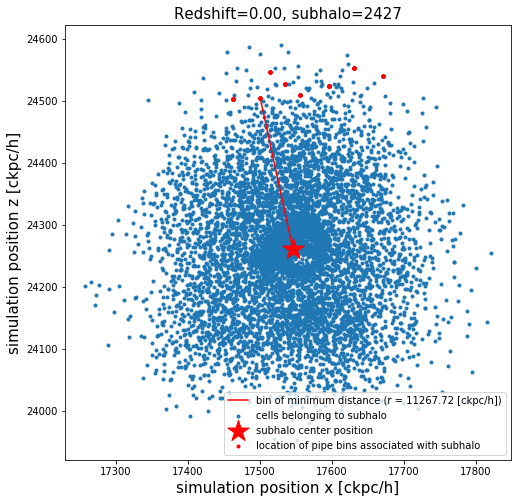

In [6]:
#adapted from https://www.tng-project.org/data/forum/topic/477/issue-with-getting-plots-for-particular-elliptical/


#plot all cells for a particular subhalo, 
#plus its central position
#plus the locations of the pipe bins which are associeated with it

#Warning: will not work if the subhalo ID is -1
print(np.all(np.unique(pipe_nearest_shIDs_p)))
if np.all(np.unique(pipe_nearest_shIDs_p)) == -1:
    print('Warning, only subhalo ID in pipe is -1. code will not work.')

else:
    subhalos_unique = np.unique(pipe_nearest_shIDs_p)
    subhalos_not_neg1 = np.where(subhalos_unique!=-1)
    subhalos_not_neg1 = subhalos_unique[subhalos_not_neg1]
    print('Subhalos which are not -1: {0}'.format(subhalos_not_neg1))

#choose subhalo
subhalo_tochoose = np.random.choice(subhalos_not_neg1)
print('Will plot subhalo {0}'.format(subhalo_tochoose))

for (i,j) in zip([snap_number],[subhalo_tochoose]):
    print(i,j)
    
    #bins associated with this subhalo
    tochoose_bin_idxs = np.where(pipe_nearest_shIDs_p==j)
    
    # coordinates of these bins
    tochoose_bin_coords = pipe_nearest_coords_p[tochoose_bin_idxs]
    print('Coordinates of bins belonging to this subhalo: {0}'.format(len(tochoose_bin_coords)))    
    
    gas = il.snapshot.loadSubhalo(basePath, i, j, 'gas', fields=None)
    subhalo = il.groupcat.loadSingle(basePath, i, subhaloID=j)
    
    #central position of the subhalo
    centralpos = subhalo['SubhaloPos']
    print('Central position of subhalo: {0}'.format(centralpos))
    
    # distances between these bins and the central position of the subhalo
    dists = np.sqrt((tochoose_bin_coords[:,0]-centralpos[0])**2 + (tochoose_bin_coords[:,1]-centralpos[0])**2 + (tochoose_bin_coords[:,2]-centralpos[0])**2)
    minDist_idx = np.argmin(dists) #index of the bin with the minimum distance
    minDist = dists[minDist_idx] #actual minimum distance (rough impact factor without algebra)
    minDist_loc = tochoose_bin_coords[minDist_idx] #coordinates of bin of minimum distance
    
    #plot
    
    if ('Coordinates' in gas.keys() ):
        #header = il.groupcat.loadHeader(basePath,i)

        gas_pos =(gas['Coordinates'])
        #sub_pos = subhalo['SubhaloPos']
        #print(sub_pos)

        #cells in the subhalo
        dx = gas_pos[:,0]# -  sub_pos[0]
        dy = gas_pos[:,1]# -  sub_pos[1]
        dz = gas_pos[:,2]# -  sub_pos[2]
        
        #central position of the subhalo
        cx = centralpos[0]
        cy = centralpos[1]
        cz = centralpos[2]
        
        #bins associated with subhalo
        bx = tochoose_bin_coords[:,0]
        by = tochoose_bin_coords[:,1]
        bz = tochoose_bin_coords[:,2]
        
        #minimum distance bin location
        mx = minDist_loc[0]
        my = minDist_loc[1]
        mz = minDist_loc[2]
        
        #print(bx,by,bz)

        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_title("Redshift={0:.2f}, subhalo={1}".format(header['Redshift'],subhalo_tochoose),fontsize=15)
        ax.set_xlabel('simulation position x [ckpc/h]',fontsize=15)
        ax.set_ylabel('simulation position z [ckpc/h]',fontsize=15)
        
        ax.scatter(dx, dz, marker='.',label='cells belonging to subhalo')
        ax.scatter(cx,cz,color='r',marker='*',s=500,label='subhalo center position')
        ax.scatter(bx,bz,color='r',marker='.',label='location of pipe bins associated with subhalo')
        ax.plot([mx,cx],[mz,cz],color='r',label = 'bin of minimum distance (r = {0:.2f} [ckpc/h])'.format(minDist))
        plt.legend()
        plt.savefig('Impact_factor_test_{0}.png'.format(sim_to_use))
        
        

In [ ]:
print('{0:02d}'.format(1))